In [1]:
# import packages
import numpy as np
import math as math
import pandas as pd
from astropy import units as u
import astropy.constants as const
import random
import matplotlib.pyplot as plt
import os
from pylaplace import LaplaceCoefficient
#import seaborn as sns; sns.set_theme()

# Exploring relationships between planet rotation, obliquity, orbital eccentricity, inclination



### $\alpha(\omega)$, precession of planet spin axis for a given spin freqency

$ \alpha $ - spin-axis precession constant

$ \epsilon $ - obliquity (of orbit?)

Period of planet spin precession
$$ T_{\alpha} = \frac{2\pi}{\alpha ~ cos \epsilon} $$ 

Caused by torque from host star on rotationally-flattened planet 

$$ \alpha = \frac{1}{2}\frac{M_{*}}{m_p}\left(\frac{R_p}{a}\right)^3\frac{k_2}{C}\omega $$




In [2]:
def get_C(k2):
    """Calculate C, the moment of inertia, from k2, the Love number"""
    
    C = (2/3)*(1 - (2/5)*((5/(k2+1)) - 1)**0.5)
    return C

In [3]:
def get_alpha(omega, mstar, mp, rp, a, k2, C):
    """
    Calculate alpha, spin-axis precession constant for frequency of planet 
    rotational spin axis precessing around orbit normal
    
    Input:
        omega: spin frequency
        
    Returns:
        alpha: frequency constant in 1/yr
    """
    alpha = 0.5 * (mstar/mp) * (rp/a)**3 * (k2/C) * omega
    
    return alpha.decompose()

In [4]:
# planet-star parameters
mstar = 1. * u.M_sun
mp = 1. * u.M_earth   # 17 Me Neptune
rp = 1. * u.R_earth   # 4 Re Neptune
a = 1. * u.astronomical_unit  # 30 AU Neptune
k2 = 0.31 # 0.2 * random.random() + 0.2  # Love number, 0.2-0.6 in Solar system
C = get_C(k2) # 0.2 * random.random() + 0.2 # moment of inertia normalized to planet
Prot = 365 * u.day #24. * u.h  # Jupiter spins once every 10 hours, which should be illegal

obl = 23.*np.pi/180. # planet obliquity 

print("Precession for a given spin freqency:")

# Calculate spin frequency 
w = (2*np.pi)/(Prot)
print(f"w = {w.to(1/u.s):.3}")

# Calculate precession constant
alpha = get_alpha(w, mstar, mp, rp, a, k2, C)
print(f"alpha(w) = {alpha:.4}")

# Calculate planet spin axis precession periodt
Ta = (2*np.pi)/(alpha) #* np.cos(obl))
print(f"T_a = {Ta.to(u.yr):.4} ")  

Precession for a given spin freqency:
w = 1.99e-07 1 / s
alpha(w) = 3.637e-15 1 / s
T_a = 5.475e+07 yr 


In [5]:
# Assumming Prot = Porb (tidal locking)
# earth
earth_alpha = get_alpha((2*np.pi)/(365*u.day), 1*u.M_sun, 1*u.M_earth, 1*u.R_earth, 1*u.astronomical_unit, 0.33, get_C(0.33))
# neputne
neptune_alpha = get_alpha((2*np.pi)/(165*u.year), 1*u.M_sun, 17*u.M_earth, 4*u.R_earth, 30*u.astronomical_unit, 1, 1)

print(f"Earth: alpha = {earth_alpha}")
print(f"Neptune: alpha = {neptune_alpha}")

Earth: alpha = 3.7920369378449785e-15 1 / s
Neptune: alpha = 2.170705416191149e-21 1 / s


The values I get for precession period are about 10x larger than the ones in the paper. 
Unsure why...I suspect units.

### $g_{LL}$, orbit nodal regression (orbit precession)

If $g_{LL} \sim \alpha$, there is spin-orbit resonance, and that can mean high obliquity :3

In [6]:
# system information 
print("Saturn-Neptune spin-orbit precession frequency")
mstar = 1. * u.M_sun   # Sun
m1 = 95.16 * u.M_earth     # Saturn
m2 = 17.15 * u.M_earth     # Neptune 
a1 = 9.573*u.AU    # Saturn
a2 = 30.178*u.AU   # Neptune
a12 = a1/a2
print(f"a12 = {a12}")

# planet mean-motion
n1 = np.sqrt((const.G * mstar)/a1**3)   # Periodt
n2 = np.sqrt((const.G * mstar)/a2**3) 
print(f"n1 = {n1.decompose():.5}; n2 = {n2.decompose():.5}")
# Laplace coefficient
laplace = LaplaceCoefficient()
# result = laplace(a, s, m, p, q)
b = laplace(a12.value, 1.5, 1, 1, 1)
print(f"b = {b}")

# calculate spin-axis precession
gll = -0.25*b*a12*( n1*(m2/(mstar+m1))*a12 + n2*(m1/(mstar+m2)) )
print(f"g_LL = {gll.to(1/u.yr):.5}")
print(f"T = 2pi/g = {((2*np.pi)/gll).to(u.Myr):.4}")

Saturn-Neptune spin-orbit precession frequency
a12 = 0.317217840811187
n1 = 6.722e-09 1 / s; n2 = 1.201e-09 1 / s
b = -1.1615290163287626
g_LL = 1.3169e-06 1 / yr
T = 2pi/g = 4.771 Myr


In [7]:
# system information 
print("Kepler-80 d(1), e(2)")
mstar = 0.58 * u.M_sun     # Kepler-80
m1 = 2.0375316 * u.M_earth     # Kepler-80 d
m2 = 2.1171352 * u.M_earth     # Kepler-80 e 
a1 = 0.0346 * u.astronomical_unit         # Kepler-80 d
a2 = 0.0456 * u.astronomical_unit         # Kepler-80 e
a12 = a1/a2
print(f"a12 = {a12}")
P1 = 3.0721466 * u.day
P2 = 4.6453821 * u.day
w1 = (2*np.pi)/ P1 # Kepler-80 d
w2 = (2*np.pi)/ P2 # Kepler-80 e
print(f"w1 = {w1:.5} \nw2 = {w2:.5}")
r1 = 1.3 * u.R_earth
r2 = 1.33 * u.R_earth

# planet mean-motion
n1 = np.sqrt((const.G * mstar)/a1**3)
n2 = np.sqrt((const.G * mstar)/a2**3)
print(f"n1 = {n1.decompose():.5}; n2 = {n2.decompose():.5}")
# Laplace coefficient
laplace = LaplaceCoefficient()
# result = laplace(a, s, m, p, q)
b = laplace(a12.value, 1.5, 1, 1, 1)
print(f"b = {b}")

# calculate spin-axis precession
gll = -0.25*b*a12*( n1*(m2/(mstar+m1))*a12 + n2*(m1/(mstar+m2)) )
#alpha1 = get_alpha(w1,mstar,m1,r1,a1,1,1).to(u.Myr**-1)
#alpha2 = get_alpha(w2,mstar,m2,r2,a2,1,1).to(u.Myr**-1)
alpha1 = (0.5 * (mstar/m1) * (r1/a1)**3 * (1/1) * w1).to(u.Myr**-1)
alpha2 = (0.5 * (mstar/m2) * (r2/a2)**3 * (1/1) * w2).to(u.Myr**-1)
print(f"g_LL = {gll.to(1/u.Myr):.5}")
print(f"alpha_d = {alpha1:.5}")
print(f"alpha_e = {alpha2:.5}")

Kepler-80 d(1), e(2)
a12 = 0.7587719298245613
w1 = 2.0452 1 / d 
w2 = 1.3526 1 / d
n1 = 2.356e-05 1 / s; n2 = 1.5572e-05 1 / s
b = -11.6543935473343
g_LL = 2.5136e+04 1 / Myr
alpha_d = 1.4551e+05 1 / Myr
alpha_e = 4.3324e+04 1 / Myr


In [8]:
get_alpha(w2,mstar,m2,r2,a2,1,1).to(u.Myr**-1)

<Quantity 1.3728596e-09 1 / s>

In [9]:
get_alpha(w1,mstar,m1,r1,a1,1,1).to(u.Myr**-1)

<Quantity 145510.79132696 1 / Myr>

In [10]:
(0.5 * (mstar/m2) * (r2/a2)**3 * (1) * w2).to(u.Myr**-1)

<Quantity 43324.15398583 1 / Myr>

In [11]:
print(f"w1 = 2pi/P1 = {w1}, n1 = GMstar/a1^3: {n1.to(u.d**-1)}")
print(f"w2 = 2pi/P2 = {w2}, n2 = GMstar/a2^3: {n2.to(u.d**-1)}")

w1 = 2pi/P1 = 2.045210116984517 1 / d, n1 = GMstar/a1^3: 2.0355477287735853 1 / d
w2 = 2pi/P2 = 1.3525658755131438 1 / d, n2 = GMstar/a2^3: 1.3453899345260363 1 / d


### Calculate obliquity required for spin-orbit resonance

$$ cos~\epsilon = \left( \frac{1}{2\alpha_{syn}/|g| ~-~1} \right)^{1/2}  $$

for $\alpha_{syn} = \alpha$ when $n = \omega$, i.e. the rotation period of the planet is the same as its orbital period 


In [61]:
(alpha1.mean() - alpha1.min())*0.25

<Quantity 29676.27484677 1 / Myr>

In [13]:
P2/P1

<Quantity 1.51209649>

In [63]:
# Assume Prot = Porb
# N random values of k2, g
N = 100
k2 = np.random.rand(N)*(0.6 - 0.1) + 0.1
g = gll*(np.random.rand(N)*(1. - 0.3) + 0.3)
alpha1 = (0.5 * (mstar/m1) * (r1/a1)**3 * (k2/get_C(k2)) * w1).to(u.Myr**-1)
alpha2 = np.random.normal(1.4e5, 3e4, N) * u.Myr**-1 # (0.5 * (mstar/m2) * (r2/a2)**3 * (k2/get_C(k2)) * w2).to(u.Myr**-1)

alpha_d_g = np.array([(alpha1 / gg).decompose() for gg in g])  # a/g for every alpha, g pair
alpha_e_g = np.array([(alpha2 / gg).decompose() for gg in g])

print(f"alpha_d/g: {(alpha_d_g).min():.4}--{(alpha_d_g).max():.4}")
print(f"alpha_e/g: {(alpha_e_g).min():.4}--{(alpha_e_g).max():.4}")

obl1 = np.arccos(((2*alpha_d_g) - 1)**(-0.5))*(180/np.pi)
obl2 = np.arccos(((2*alpha_e_g) - 1)**(-0.5))*(180/np.pi)
print(f"obliquity_d = {obl1.min():.4}--{obl1.max():.4} deg (P = {P1})")
print(f"obliquity_e = {obl2.min():.4}--{obl2.max():.4} deg (P = {P2})")

alpha_d/g: 3.626--39.01
alpha_e/g: 3.0--31.69
obliquity_d = 66.43--83.46 deg (P = 3.0721466 d)
obliquity_e = 63.44--82.73 deg (P = 4.6453821 d)


In [45]:
np.array([(alpha1 / gg).decompose() for gg in g])

array([[18.26974543, 18.2545191 , 13.46629031, ..., 16.30857821,
        18.23504914, 14.05156315],
       [16.90615818, 16.89206829, 12.46121545, ..., 15.09136534,
        16.87405149, 13.00280567],
       [19.42709569, 19.41090481, 14.31935171, ..., 17.34169263,
        19.39020146, 14.94170037],
       ...,
       [18.83562043, 18.81992249, 13.88338627, ..., 16.81370932,
        18.79984948, 14.48678697],
       [16.87839831, 16.86433155, 12.44075417, ..., 15.06658536,
        16.84634434, 12.98145509],
       [18.58069102, 18.56520554, 13.69548253, ..., 16.58614533,
        18.54540421, 14.29071655]])

### Planet tilt ($\omega$) vs. day length (n)
Obliquity vs. spin frequency

$$ \frac{w_{eq}}{n} = \frac{N(e)}{\Omega(e)}\frac{2cos~\epsilon}{1 + cos^2\epsilon} $$

$ N(e=0) = \Omega(e=0) = 1$

Solving for $\epsilon$ when $w_{eq}/n = 1$:

$$ \epsilon = cos^{-1} \left( \frac{N(e)}{\Omega(e)} \pm  \sqrt{\left( \frac{N(e)}{\Omega(e)}\right) ^2 - 1} ~\right)$$ 

but the part under the radical is complex, so it's actually

$$ \epsilon = cos^{-1} \left( \frac{N(e)}{\Omega(e)}\right) $$

Text(0.5, 1.0, 'Mean rotation rate vs. travel rate for all obliquities @ e=0')

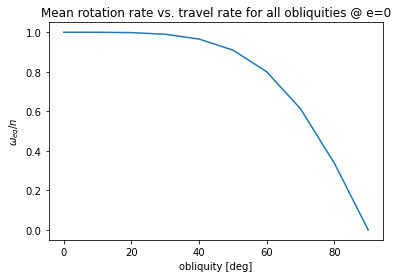

In [16]:
obl = np.arange(0,100,10) * np.pi/180
weq_n = (2 * np.cos(obl)) / (1 + np.cos(obl)**2)

plt.plot(obl*180/np.pi, weq_n)
plt.xlabel("obliquity [deg]")
plt.ylabel(r"$\omega_{eq}/n$")
plt.title("Mean rotation rate vs. travel rate for all obliquities @ e=0")

In [17]:
_obl = np.linspace(0,90,100) * np.pi/180
_ecc = np.linspace(0,0.10,100)

obl, ecc = np.meshgrid(_obl, _ecc)

Ne = (1 + (15/2)*ecc**2 + (45/8)*ecc**4 + (5/16)*ecc**6) / (1 - ecc**2)**6
Omegae = (1 + 3*ecc*2 + (3/8)*ecc**4) / (1 - ecc**2)**(9/2)
weq_n =  (2 * np.cos(obl)) / (1 + np.cos(obl)**2)# * (Ne / Omegae) 

obl_lock = np.arccos((Ne / Omegae))  # + np.sqrt((Ne/Omegae)**2 - 1)

**Note** The plot has a gradient with increasing eccentricity if you include the 
$\frac{N(e)}{\Omega(e)}$ term in the calculation for $w_{eq}/n$.

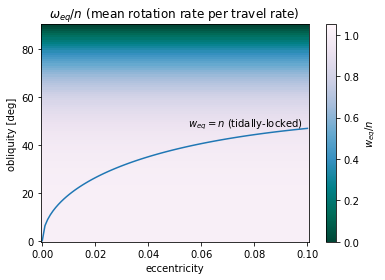

In [18]:
fig, ax = plt.subplots()
plt.grid(False)

pcm = ax.pcolormesh(ecc, obl*(180/np.pi), weq_n, 
                    cmap='PuBuGn_r', vmin=0, vmax=1.05)
plt.plot(np.unique(ecc.flatten()), np.unique((obl_lock.flatten())) * (180/np.pi), '-')

plt.text(0.055, 48, r"$w_{eq} = n$ (tidally-locked)")
plt.xlabel("eccentricity")
plt.ylabel("obliquity [deg]")
plt.title(r"$\omega_{eq}/n$ (mean rotation rate per travel rate) ")
cb = fig.colorbar(pcm)
cb.set_label(r"$w_{eq}/n$")

In [19]:
mass_data = pd.read_table("./ajaa71eft1_mrt.txt", header=70, usecols=[0])
# ecc_data = pd.read_table("./ajaa71eft2_mrt.txt", header=28)

In [20]:
mass_data.to_numpy()[0:5]

array([['Kepler-9 b    1  19.243  8.2 1.0  0.7    1.0 0.1  0.1  0  43.5   2.7  3.3    0.4   0.1  0.1  0  43.4   2.7  3.2    0.4    0.1  0.1  Ho10; Dr14; Bo14        '],
       ['Kepler-9 c    1  38.969  8.3 0.8  0.9    1.0 0.1  0.1  0  29.9   1.8  2.3    0.3   0.1  0.1  0  29.9   1.9  2.2    0.3    0.1  0.1  Ho10; Dr14; Bo14        '],
       ['Kepler-11 b   0  10.304  1.9 0.1  0.1    0.9 0.1  0.1  0   0.7   0.3  0.2    0.6   0.3  0.2  0   1.2   0.6  0.5    1.0    0.5  0.5  Li11; Mig12; Li13; Bo14 '],
       ['Kepler-11 c   0  13.025  3.0 0.2  0.2    0.9 0.1  0.1  0   1.8   0.9  0.5    0.4   0.2  0.1  0   3.4   1.4  1.5    0.7    0.4  0.3  Li11; Mig12; Li13; Bo14 '],
       ['Kepler-11 d   1  22.687  3.3 0.2  0.2    0.9 0.1  0.1  0   6.8   0.7  0.8    1.0   0.2  0.2  0   6.9   0.8  0.8    1.0    0.3  0.2  Li11; Mig12; Li13; Bo14 ']],
      dtype=object)

### g and $\alpha$ connecting to $\omega_{eq}/n$ 

If $T_g \approx T_{\alpha}$, that is **resonance** in Cassini state 2, 
and _**not**_ tidal locking, right?  This is just saying the precession period of the orbit is the same as the precession period of the planet spin. Tidal locking is when $w_{eq} = n$

Sarah has gone ahead and calculated $g$ and $\alpha_{sync} = a(n\omega)$ for M dwarfs which are also in the paper by Hadden & Lithwick. 

For $e \approx 0$, she used an expression which has $\alpha_{syn},~g$ to get $\epsilon$:

$$ cos~\epsilon = \left( \frac{1}{2\alpha_{syn}/|g| - 1} \right)^{1/2} $$. 

I will now look up the values of $w_{eq}/n$.

In [21]:
# Trappist-1 values
pl_c_obl = [69.7, 80.5, 78.3, 85.0] # min, max b-c; min-max c-d obliquity
pl_c_ag = [4.66, 19., 12.7, 66.6] # min, max b-c; min-max c-d  alpha/g
pl_c_n = 2*np.pi / (2.42 * u.d) 

Planet c rotation period range given b-c interactions: [3.92202834 7.53092573] d
Planet c rotation period range given c-d interactions: [ 6.21221586 13.71923397] d
saving figure TRAPPIST-1/plots/TRAPPIST-1_obliquity_weqn.pdf


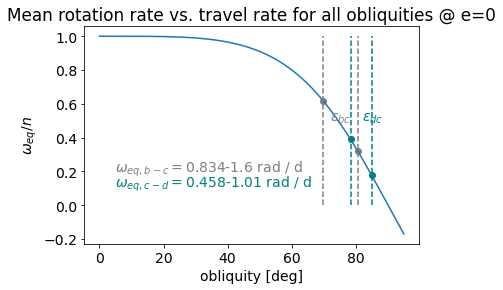

In [22]:
plt.rc('font', size=14) 
plt.xlabel("obliquity [deg]")
plt.ylabel(r"$\omega_{eq}/n$")
plt.title("Mean rotation rate vs. travel rate for all obliquities @ e=0")

obl = np.arange(0,95,0.1) * np.pi/180
weq_n = (2 * np.cos(obl)) / (1 + np.cos(obl)**2)

# mask for allowed obliquities for each planet-planet interaction
bc_obl_mask = (obl > pl_c_obl[0]*(np.pi/180) )& (obl < pl_c_obl[1]*(np.pi/180)) # deg
cd_obl_mask = (obl > pl_c_obl[2]*(np.pi/180) )& (obl < pl_c_obl[3]*(np.pi/180)) # deg

# b-on-c
weq_n_bc = [weq_n[bc_obl_mask].min(), weq_n[bc_obl_mask].max()]
weq_bc = (weq_n_bc * u.rad) * pl_c_n
print(f"Planet c rotation period range given b-c interactions: {np.sort(np.pi*2*u.rad/weq_bc)}")
plt.scatter(obl[bc_obl_mask].min()*(180/np.pi), weq_n[bc_obl_mask].max(),c='grey')
plt.scatter(obl[bc_obl_mask].max()*(180/np.pi), weq_n[bc_obl_mask].min(),c='grey')
plt.text(5,0.2, r"$\omega_{eq, b-c} = $"+f"{weq_bc[0].value:.3}-{weq_bc[1]:.3}", c='grey')

# d-on-c
weq_n_cd = [weq_n[cd_obl_mask].min(), weq_n[cd_obl_mask].max()]  # range of weq/n
weq_cd = (weq_n_cd * u.rad) * pl_c_n    
print(f"Planet c rotation period range given c-d interactions: {np.sort(np.pi*2*u.rad/weq_cd)}")
plt.scatter(obl[cd_obl_mask].min()*(180/np.pi), weq_n[cd_obl_mask].max(),c='teal')
plt.scatter(obl[cd_obl_mask].max()*(180/np.pi), weq_n[cd_obl_mask].min(),c='teal')
plt.text(5,0.11, r"$\omega_{eq, c-d} = $"+f"{weq_cd[0].value:.3}-{weq_cd[1]:.3}", c='teal')

# plot obliquity-weq/n curve
plt.plot(obl*180/np.pi, weq_n)

plt.vlines(pl_c_obl[0:2], 0,1, linestyles='--', colors='grey')
plt.text(72, 0.5, r"$\epsilon_{bc}$", c='grey')
plt.vlines(pl_c_obl[2:], 0,1, linestyles='--', colors='teal')
plt.text(82, 0.5, r"$\epsilon_{dc}$", c='teal');

saveplot=True
if saveplot:
    folder = f"TRAPPIST-1"
    if not os.path.exists(folder):
        print(f"making {folder}")
        os.makedirs(f"{folder}/plots")
    filename=f"{folder}/plots/{folder}_obliquity_weqn.pdf"
    plt.savefig(filename, bbox_inches='tight',transparent=True)
    print(f"saving figure {filename}")